<a href="https://colab.research.google.com/github/arieles08/TP1_DMCyT/blob/main/TP1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##      **TP1**
#                2do cuatrimestre 2022 

**Clustering de Imágenes**

### Librerias y Paquetes

In [ ]:
#1 for loading/processing the images:
#from keras.preprocessing.image import load_img  
#from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

#2 models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

#3 clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#3 for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import random
#import pickle

#from IPython.display import Audio, Markdown, Image
import seaborn as sns

# Clustering Jerarquico
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import squareform

In [ ]:
#instala medida de distancia de gower (para Variables Mixtas)
!pip install gower
import gower

In [ ]:
#Agrego scikit learn extra para el script de PAM
%%script echo skipping
!pip install git+https://github.com/scikit-learn-contrib/scikit-learn-extra.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-learn-contrib/scikit-learn-extra.git to /tmp/pip-req-build-8d9l0z68
  Running command git clone -q https://github.com/scikit-learn-contrib/scikit-learn-extra.git /tmp/pip-req-build-8d9l0z68
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


### Definición de Funciones

In [ ]:
#1° Descarga Modelo de Redes Neuronales Convolucionales pre-entrenado VGG16 con 16 capas, para Transfer Learning:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [ ]:
#2° -> redimensiona a imagenes a 224x224 -> las redimensiona a un arrar
def extract_features(file, model):
    # levanta imagen como array 224x224 
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image') 
    img = np.array(img) 
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
#3° 
def preprocess(lista, model):
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress               
    # lista de filenames
    filenmss = np.array(list(datays.keys()))
    
    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens 
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

In [ ]:
#extra: Funcion para visualizar clusters (independiente de 1,2y3)
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

# 0.**Preparación de los datos**

### (a) Levantar las imágenes y sus etiquetas.
### (b) Documentar las propiedades del dataset a utilizar.
### (c) Describir sus atributos, de forma semejante a lo realizado en el pre-informe.
### (b) Documentar las propiedades del dataset a utilizar.

#### Carga del dataset **Total** de imagenes (path + crear etiquetas): 

In [ ]:
#Acceso a Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.1 **path**:

In [ ]:
# PASO 1.1: Crear variable "path" con el listado de las rutas de todas las imagenes --> Nota: CAMBIAR RUTA DE ARCHIVOS A LA DE CADA UNO
ruta = '/content/drive/MyDrive/Colab Notebooks/natural_images'

from pathlib import Path
path = [ archivo.as_posix() for archivo in Path(ruta).glob('*/*')]
path[0:4]                        

['/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0003.jpg']

1.2 **etiquetas**

In [ ]:
# PASO 1.2: Crear un dataset con las etiquetas correspondiente a cada imagen dentro del listado 'path' generado:
df_labels = pd.DataFrame(columns=['file', 'label'])
start = len(ruta) + 1
for i in range(len(path)):
  end = path[i].find("/", start)
  file = path[i][start:] 
  label = path[i][start: end] 
  df_labels = df_labels.append({'file' : file, 'label' : label}, ignore_index=True)

df_labels[0:4]

file     label
0  airplane/airplane_0000.jpg  airplane
1  airplane/airplane_0001.jpg  airplane
2  airplane/airplane_0002.jpg  airplane
3  airplane/airplane_0003.jpg  airplane

#### **Atritubos** de **TODO** el Dataset

In [ ]:
#Cantidad de imagenes totales: 6899
len(path)

6702

In [ ]:
#Etiquetas
labels = df_labels['label'].unique()
print(len(labels), 'labels ->', labels)

8 labels -> ['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


In [ ]:
#Cantidades por Categorías: 
df_labels['label'].value_counts(sort = False)

airplane      530
car           968
cat           885
dog           702
flower        843
fruit        1000
motorbike     788
person        986
Name: label, dtype: int64

#### Seleccion de **una MUESTRA** de 2000 imágenes con **250 imágenes por categoria**
> path_muestra

> df_labels_m

##### 2.1 **path_muestra**: con la ruta de las 1000 imagenes de MUESTRA

In [ ]:
#Selecciono UNA MUESTRA con las primeras n=125 imagenes por categoria:
n = 250

#Recorre las 8 etiquetas para tomar una Muestra de las primeras 125 imagenes:
path_muestra = list()
for i in range(len(labels)):
  filtro = ( df_labels.label == labels[i] )
  select = df_labels[filtro][0:(n+1)].index
  p = path[select[0]:select[n]]
  path_muestra = path_muestra + p

path_muestra[0:3] + path_muestra[n:n+3] + path_muestra[n*2:(n*2)+3] + path_muestra[n*7:(n*7)+3]

['/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/car/car_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/car/car_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/car/car_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/person/person_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/person/person_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/person/person_0002.jpg']

##### 2.2 Dataset con las **etiquetas de la MUESTRA**:  **df_labels_m**

In [ ]:
# PASO 2: Crear un dataset con las etiquetas correspondiente a cada imagen dentro del listado 'path' generado:
df_labels_m = pd.DataFrame(columns=['file', 'label', 'path'])
start = len(ruta) + 1
for i in range(len(path_muestra)):
  end = path_muestra[i].find("/", start)
  file = path_muestra[i][start:] 
  label = path_muestra[i][start: end] 
  path = path_muestra[i]
  df_labels_m = df_labels_m.append({'file' : file, 'label' : label, 'path':path}, ignore_index=True)

df_labels_m[0:4]

file     label  \
0  airplane/airplane_0000.jpg  airplane   
1  airplane/airplane_0001.jpg  airplane   
2  airplane/airplane_0002.jpg  airplane   
3  airplane/airplane_0003.jpg  airplane   

                                                path  
0  /content/drive/MyDrive/Colab Notebooks/natural...  
1  /content/drive/MyDrive/Colab Notebooks/natural...  
2  /content/drive/MyDrive/Colab Notebooks/natural...  
3  /content/drive/MyDrive/Colab Notebooks/natural...

##### 2.3 Dataframe para la ***selección de ejemplos***: **' ejn '**


In [ ]:
#datafraem con Numero del path_muestra para poder seleccionar ejemplos de cada Categoria:

# genero un diccionario
d = dict()
for i in range(len(labels)):
  d[labels[i]] = df_labels_m[df_labels_m.label == labels[i]].index

#lo paso a un dataframe
ejn = pd.DataFrame(d)
ejn[0:3]

airplane  car  cat  dog  flower  fruit  motorbike  person
0         0  250  500  750    1000   1250       1500    1750
1         1  251  501  751    1001   1251       1501    1751
2         2  252  502  752    1002   1252       1502    1752

person


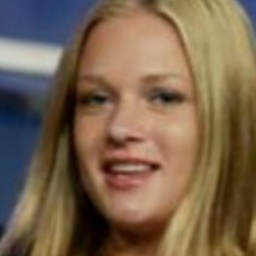

In [ ]:
#selecciono 1 ejemplo de la N categoria
N = 7
print(labels[7])
load_img(path_muestra[ejn.iloc[0,N]])

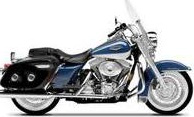

In [ ]:
# selecciono 1 ejemplos de 'motorbike'
load_img(path_muestra[ejn['motorbike'][0]])

In [ ]:
img = load_img(path_muestra[ejn['motorbike'][0]])

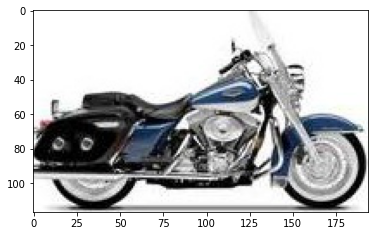

In [ ]:
img = np.array(img)
img = np.array(img)
plt.imshow(img)

In [ ]:
len(img[0])

194

#### **Atritubos** de **la MUESTRA** del Dataset 


In [ ]:
#Cantidad de imagenes MUESTRA: 1000
len(path_muestra)

2000

In [ ]:
#Etiquetas MUESTRA:
labels = df_labels_m['label'].unique()
print(len(labels), 'labels ->', labels)

8 labels -> ['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


In [ ]:
#Cantidades por Categorías: 
df_labels_m['label'].value_counts(sort = False)

airplane     250
car          250
cat          250
dog          250
flower       250
fruit        250
motorbike    250
person       250
Name: label, dtype: int64

#### **Propiedades** del dataset:
esta compuesto por imagenes de diferentes dimensiones, pero que luego se redimensionan en imagenes de 224 x 224, para homogeneizarlas y asi poder usarlas en los algoritmos de generación de features, clustering etc.

size1: pixeles de alto

size2: pixeles de ancho

vemos en las imagenes a continuación ademas de la diferencia de tamaño, muestra la escala en pixeles de alto y ancho, y se aprecia que son diferentes unos de otro

el dataset se obtuvo de: kaggle.com/datasets/prasunroy/natural-images

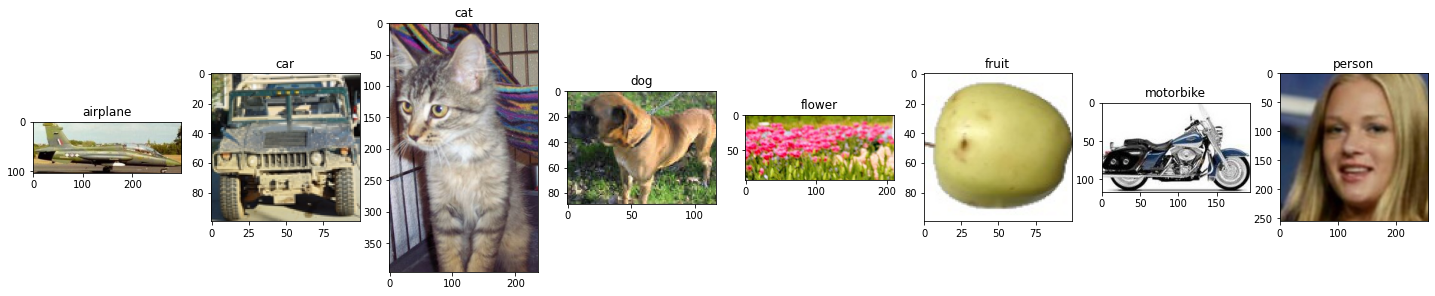

In [ ]:
# 1 Ejemplo de cada categoria --> tienen las imagenes diferentes dimensiones
plt.figure(figsize = (25,25))
for i in range(len(labels)):
  plt.subplot(1,8,i+1)
  img = load_img(path_muestra[ejn.iloc[0,i]])
  img = np.array(img)
  plt.imshow(img)
  plt.title(str(labels[i]))
  #plt.axis('off')  

# 1. **Extracción de features**
Se propone el uso de **un modelo de redes neuronales convolucionales VGG16**, es un **modelo de Transfer Learning que posee 16 capas (con pesos) pre entrenado** para clasificación de imágenes. 

Dicho modelo está **implementado en Keras** https://keras.io/api/applications/vgg/ y por default **trabaja con imágenes de 224x224**.
Este modelo es **entrenado de forma supervisada** para clasificación y **aprende en las capas intermedias** características que son relevante para dicha tarea. En el presente trabajo les proponemos utilizar estas características utilizando la salida de las capas intermdias.

Siguiendo los pasos descriptos en las clases, **explorar el output del modelo y documentar el proceso y las características del mismo**.

Se usa un modelo de Redes Neuronales Convolucionales pre-entrenado con 16 capas, el VGG16 de la libreria keras,  para realizar Transfer Learning.

### Explicación de los **pasos** dentro de la funcion 'extract_features(file, model):

**1)** Se redimensionan las imagenes a 224 x 224 pixeles para poder trabajarlas con el modelo VGG16

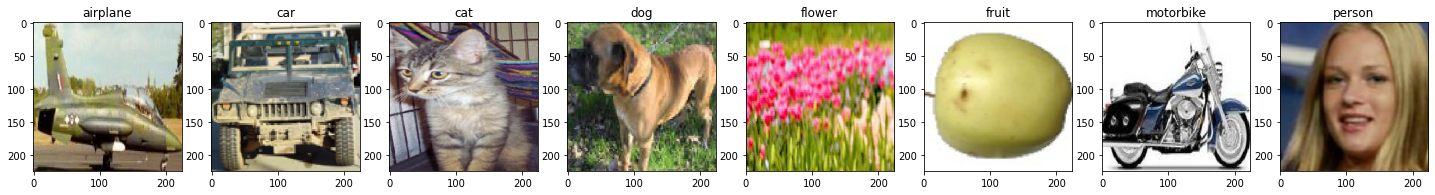

In [ ]:
# 1 Se redimensionan las imagenes a un formato de 224 x 224 al cargarse
plt.figure(figsize = (25,25))
for i in range(len(labels)):
  plt.subplot(1,8,i+1)
  img = load_img(path_muestra[ejn.iloc[0,i]], target_size=(224,224))
  img = np.array(img)
  plt.imshow(img)
  plt.title(str(labels[i]))
  #plt.axis('off')  

**2)** Esas imagenes se transforman en un array y se pasan al formato adecuado para trabajar con un lote de imagenes en keras, el cual es:
(num_samples, size1,size2,channels) -> (1,224, 224, 3)

In [ ]:
# Replico los pasos dentro de la funcion 'extract_features(file, model)' --> donde redimensiona todas las imágenes (pero lo hago en una sola de ejemplo)

img = load_img(path_muestra[0], target_size=(224,224))
img = np.array(img)
reshaped_img = img.reshape(1,224,224,3)
print(len(reshaped_img),len(reshaped_img[0]),len(reshaped_img[0][0]),len(reshaped_img[0][0][0]))

1 224 224 3


**3)** Se aplica una función proporcionada por Keras llamada 'preprocess_input()' de keras, para preparar nuevas entradas para el modelo de red neuronal que usaremos.

Sigue generando array(1, 224, 224, 3) como se le ingresó, pero el output modifica los valores de entrada, que eran valores enteros de 0 a 256, a un rango continuo que incluye negativos y positivos (no se con que criterio los transforma y no importa tampoco)

In [ ]:
# aplica la función "preprocess_input()" sobre la imagen transformada previamente en un array de (1, 224, 224, 3)
imgx = preprocess_input(reshaped_img)
print(  preprocess_input(reshaped_img).min(), 
        preprocess_input(reshaped_img).max()     )

-123.68 144.061


**4) Output**: Finalmente usa el modelo VGG16 para predecir, el cual arroja como output las 4096 features nuevas generadas para cada imagen cargada

-> el OUTPUT es descrito un poco mas en detalle abajo, despues de correrlo para todas las imagenes

In [ ]:
features = model.predict(imgx, use_multiprocessing=True)
print(len(features[0]), 'features nuevas -> ', features)

1/1 [==============================] - 1s 706ms/step
4096 features nuevas ->  [[0.69125587 0.         3.3727517  ... 3.867177   0.         0.        ]]


### Genero los **nuevos 4096 features** con el **modelo VGG16** para *nuestro Dataset de imagenes (MUESTRA)*

Aplicamos la funcion ***preprocess(lista, model)*** arriba definida, para simplemente aplicar los 4 pasos antes vistos, a todo el listado de imagenes contenidas en nuestro archivo 'path_muestra' (2000 imagenes)

El **OUTPUT**: es la ruta de cada imagen (path) y una lista con los 4096 features nuevos creados para esa imagen, para c/u de las imagenes

In [ ]:
# Aplicamos la funcion 'preprocess()' 
#-> que levanta las imagenes en 224x224 -> las transforma para ser tomada por la red neuronal de keras 
#-> y le aplica el modelo VGG16 a c/u de las imagenes:

#%%script echo skipping --> si queremos omitir esta celda porque tarda, en caso de ya tenerla corrida
names, feat = preprocess(path_muestra, model) 

In [ ]:
{'feat':feat}

{'feat': array([[6.9125587e-01, 0.0000000e+00, 3.3727517e+00, ..., 3.8671770e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 2.9794054e+00, ..., 3.9517019e+00,
         0.0000000e+00, 3.8262969e-01],
        [0.0000000e+00, 0.0000000e+00, 2.1526444e+00, ..., 1.5364101e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 1.5575285e+00],
        [2.0089746e-03, 1.6995859e-01, 0.0000000e+00, ..., 0.0000000e+00,
         6.0898554e-01, 0.0000000e+00],
        [1.0680076e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)}

In [ ]:
#exportarmos el listado con las 4096 features para cada una de las imagenes, para no tener que correrla de nuevo
pd.DataFrame(feat).to_csv('features_new_4096.csv')

In [ ]:
# la recuperamos (hay que guardar el csv en la misma carpeta de natural_images donde estan las imagenes en google drive)
dfeat = pd.read_csv(ruta+'/features_new_4096.csv')
feat = np.array(dfeat.iloc[:,1:]) 

In [ ]:
len(feat[0])

4096

In [ ]:
feat

array([[6.9125587e-01, 0.0000000e+00, 3.3727517e+00, ..., 3.8671770e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.9794054e+00, ..., 3.9517019e+00,
        0.0000000e+00, 3.8262970e-01],
       [0.0000000e+00, 0.0000000e+00, 2.1526444e+00, ..., 1.5364101e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.5575285e+00],
       [2.0089746e-03, 1.6995859e-01, 0.0000000e+00, ..., 0.0000000e+00,
        6.0898554e-01, 0.0000000e+00],
       [1.0680076e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

#### **Analizo el OUTPUT** del Modelo VGG16

In [ ]:
#vemos un ejemplo del OUTPUT de la funcion preprecess()--> names trae la dir path de la imagen --> y feat: trae los 4096 features creados
print(names[0], '->', len(feat[0]), '->', feat[0])

/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0000.jpg -> 4096 -> [0.69125587 0.         3.3727517  ... 3.867177   0.         0.        ]


In [ ]:
# names (output de 'preprocess()')--> tiene exacto el mismo listado que el path_muestra 
pd.Series(names == path_muestra).value_counts()

True    2000
dtype: int64

Vemos ¿cómo son las nuevas 4096 features generadas? de las 224 x 214 x 3 originales, que eran todas enteros de 0 a 256
-> obtenemos valores

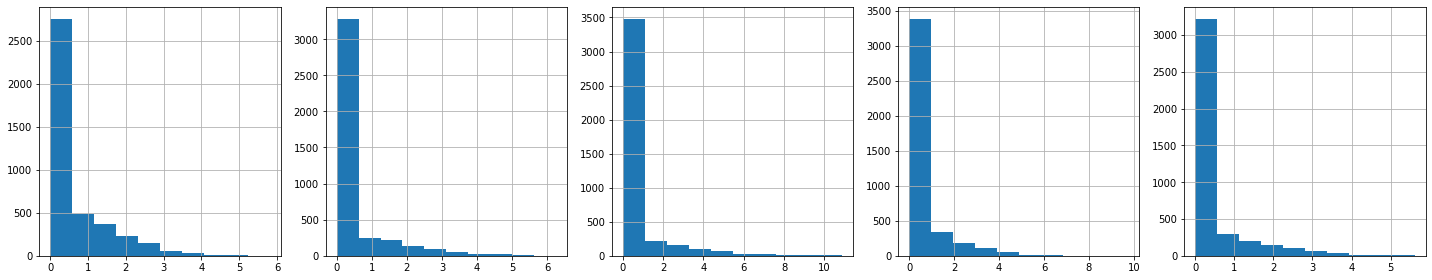

In [ ]:
#vemos la distribución los valores que toman las features para un elemento random dentro de las 2000 muestras:
#seleccionamos 5 numeros random de las 2000 imagenes:
sel = list()
for i in range(0,5):
 sel.append(random.randrange(2000))

#graficamos los 5 ejemplos:
plt.rcParams["figure.figsize"] = [(4*5), 4]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1,5)
for i in range(0,5):
  pd.Series(feat[sel[i]]).hist(ax=axes[i])
plt.show()

In [ ]:
#vemos ¿que traen las nuevas feates generadas por el modelo VGG16?:
ej1_airplan = pd.Series(feat[0]).describe()
ej1_car = pd.Series(feat[250]).describe()
ej1_cat = pd.Series(feat[500]).describe()
ej1_dog = pd.Series(feat[750]).describe()
ej1_flower = pd.Series(feat[1000]).describe()
ej1_fruit = pd.Series(feat[1250]).describe()
ej1_motorbike = pd.Series(feat[1500]).describe()
ej1_person = pd.Series(feat[1750]).describe()

dout = pd.concat([ej1_airplan, ej1_car, ej1_cat, ej1_dog, ej1_flower, ej1_fruit, ej1_motorbike, ej1_person], axis = 1)
dout.columns = 'ej1' + labels
dout

ej1airplane       ej1car       ej1cat       ej1dog    ej1flower  \
count  4096.000000  4096.000000  4096.000000  4096.000000  4096.000000   
mean      0.552501     0.516980     0.443397     0.589694     0.582302   
std       1.076322     0.965137     1.117111     1.409508     1.133555   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.660845     0.637794     0.000000     0.007279     0.737335   
max       7.003541     6.898218     9.951898    10.014935    10.489414   

          ej1fruit  ej1motorbike    ej1person  
count  4096.000000   4096.000000  4096.000000  
mean      0.502759      0.470803     0.390010  
std       1.198681      1.105453     0.789987  
min       0.000000      0.000000     0.000000  
25%       0.000000      0.000000     0.000000  
50%       0.000000      0.000000     0.000000  
75%       0.009880      0.044258     0.380419  
max      10.353857      7.511940     5.577718

In [ ]:
# num de ejemplo
ejn.iloc[0,:]

airplane        0
car           250
cat           500
dog           750
flower       1000
fruit        1250
motorbike    1500
person       1750
Name: 0, dtype: int64

# 2. **Clustering**

## 2.1 KMeans

Se aplica PCA para disminuir la cantidad de Features nuevas desde las 4096 creadas

In [ ]:
#ya no es necesario --> se creo la muestra --> path_muestra
#random.seed(10)
#path = random.sample(path, 1000)

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 4096
Components after PCA: 100


### 2.1.1 KMeans con parametros por default

* init: k-means++
* n_initint =10
* max_iterint= 300
* tolfloat=1e-4
* algorithm=”lloyd”

#### (a) **Aplicar KMeans** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters** utilizando **silhuette y SSE.**


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    Kmeans = KMeans(n_clusters=k).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['dog' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['cat' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['person' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['motorbike' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['fruit' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['car' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['airplane' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['flower' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

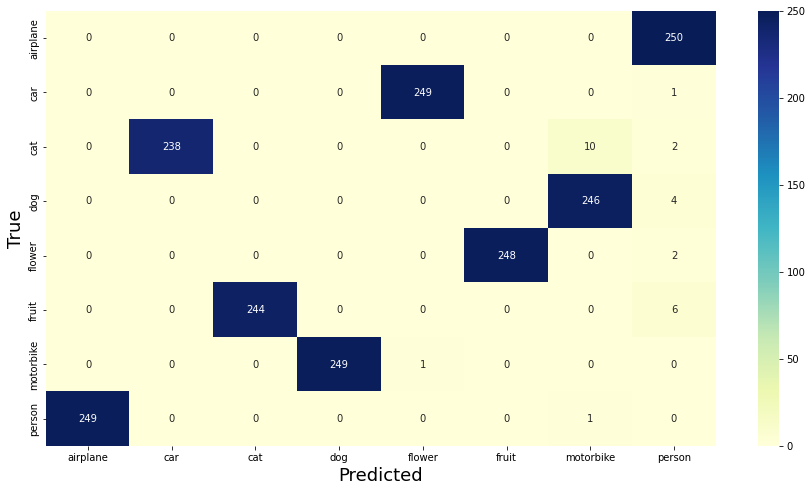

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

0.9933146573286643

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


Labels       airplane  car  cat  dog  flower  fruit  motorbike  person
Labels_test                                                           
airplane            0    0    0    0       0      0          0     250
car                 0    0    0    0     249      0          0       1
cat                 0  238    0    0       0      0         10       2
dog                 0    0    0    0       0      0        246       4
flower              0    0    0    0       0    248          0       2
fruit               0    0  244    0       0      0          0       6
motorbike           0    0    0  249       1      0          0       0
person            249    0    0    0       0      0          1       0

In [ ]:
vanDongen(ct)

0.015494978479196557

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

([], <a list of 0 Text major ticklabel objects>)

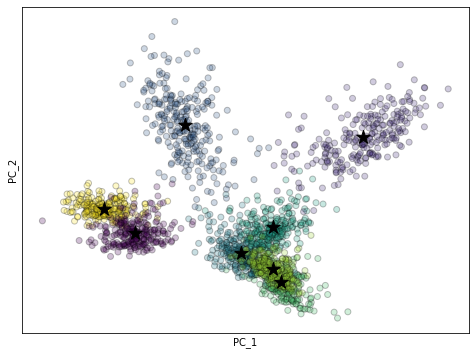

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


In [ ]:
# Levanta archivos y extrae features --> tarda bastante en correrse --> por eso es que se elige una muestra
names, feat = preprocess(path, model)

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 4096
Components after PCA: 100


#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

### 2.1.2 KMeans combinación de otros parámetros 1

* init: k-means++
* n_initint =20
* max_iterint= 5000
* tolfloat=1e-5
* algorithm=”lloyd”

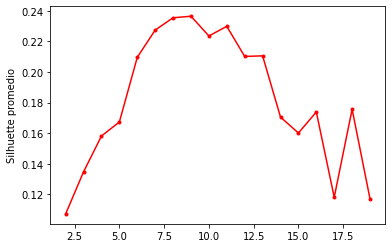

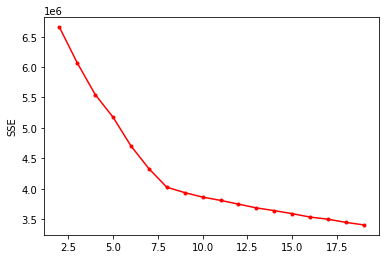

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    Kmeans = KMeans(n_clusters=k, random_state=22, n_init=20, max_iter=500, tol=0.00001).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22, n_init=20, max_iter=500, tol=0.00001)
kmeans.fit(x)

KMeans(max_iter=500, n_init=20, random_state=22, tol=1e-05)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

Clipping cluster size from 245 to 10
Clipping cluster size from 249 to 10
Clipping cluster size from 238 to 10
Clipping cluster size from 249 to 10
Clipping cluster size from 247 to 10
Clipping cluster size from 250 to 10
Clipping cluster size from 257 to 10
Clipping cluster size from 265 to 10


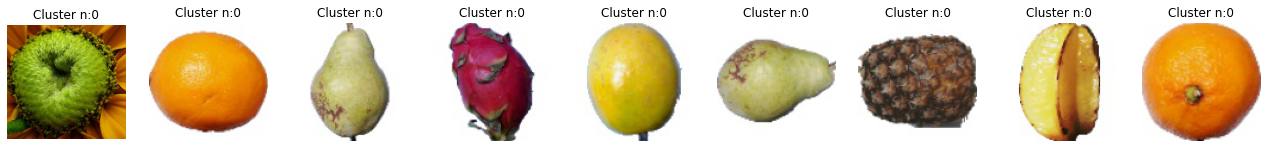

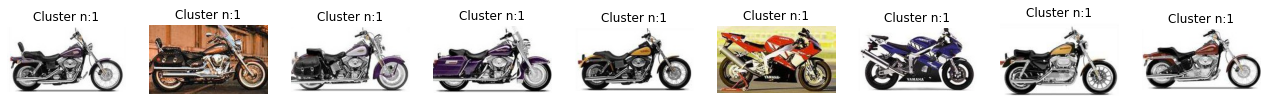

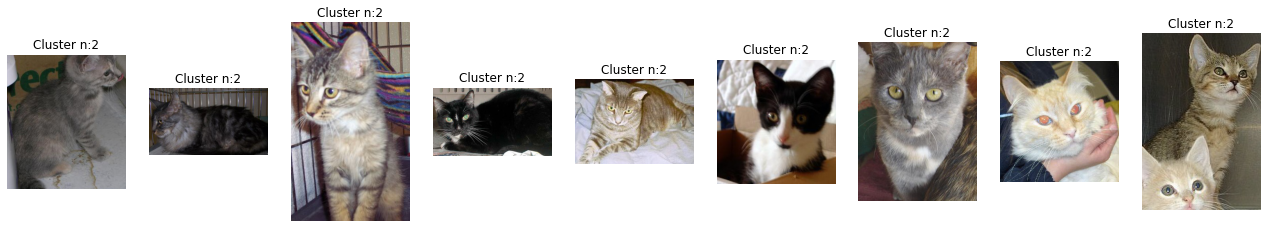

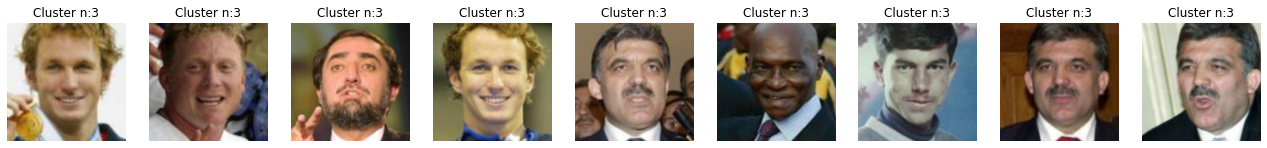

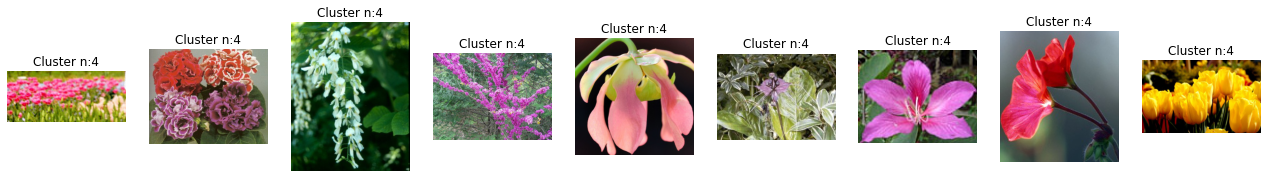

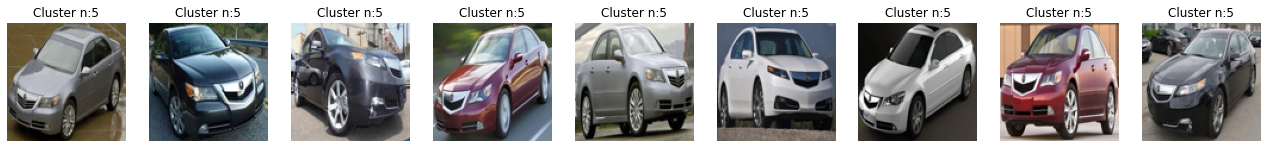

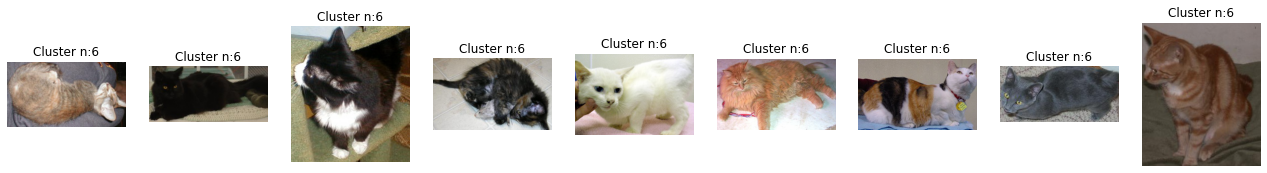

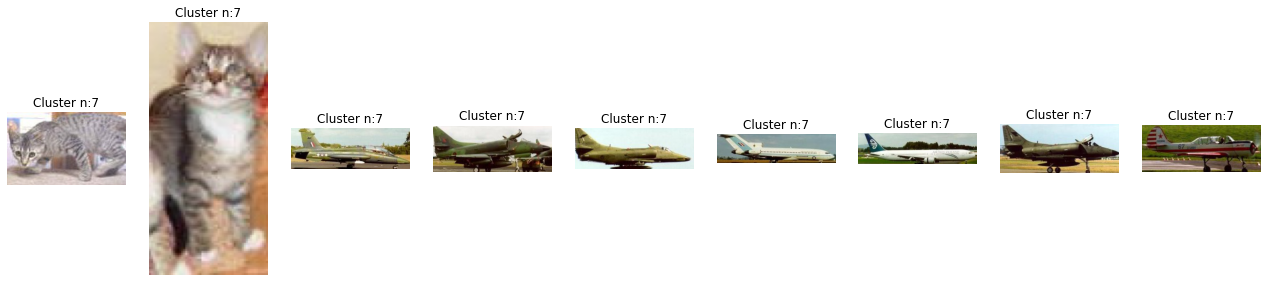

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['flower' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['person' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['dog' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['car' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['cat' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['airplane' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['motorbike' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['fruit' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

path  Labels Labels_test
0    /content/drive/MyDrive/Colab Notebooks/natural...  flower      flower
1    /content/drive/MyDrive/Colab Notebooks/natural...  flower       fruit
2    /content/drive/MyDrive/Colab Notebooks/natural...  flower       fruit
3    /content/drive/MyDrive/Colab Notebooks/natural...  flower       fruit
4    /content/drive/MyDrive/Colab Notebooks/natural...  flower       fruit
..                                                 ...     ...         ...
260  /content/drive/MyDrive/Colab Notebooks/natural...   fruit       fruit
261  /content/drive/MyDrive/Colab Notebooks/natural...   fruit       fruit
262  /content/drive/MyDrive/Colab Notebooks/natural...   fruit       fruit
263  /content/drive/MyDrive/Colab Notebooks/natural...   fruit       fruit
264  /content/drive/MyDrive/Colab Notebooks/natural...   fruit       fruit

[2000 rows x 3 columns]

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

path  Labels Labels_test
0  /content/drive/MyDrive/Colab Notebooks/natural...  flower      flower

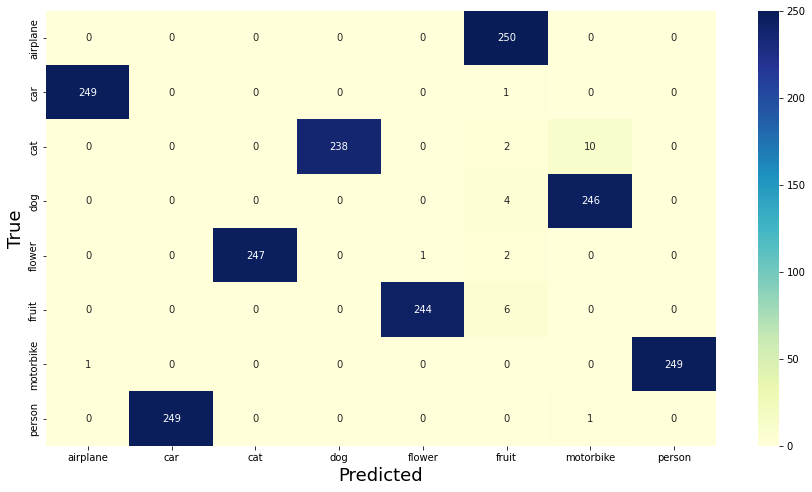

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

0.9930690345172586

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


Labels       airplane  car  cat  dog  flower  fruit  motorbike  person
Labels_test                                                           
airplane            0    0    0    0       0    250          0       0
car               249    0    0    0       0      1          0       0
cat                 0    0    0  238       0      2         10       0
dog                 0    0    0    0       0      4        246       0
flower              0    0  247    0       1      2          0       0
fruit               0    0    0    0     244      6          0       0
motorbike           1    0    0    0       0      0          0     249
person              0  249    0    0       0      0          1       0

In [ ]:
vanDongen(ct)

0.01606886657101865

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

([], <a list of 0 Text major ticklabel objects>)

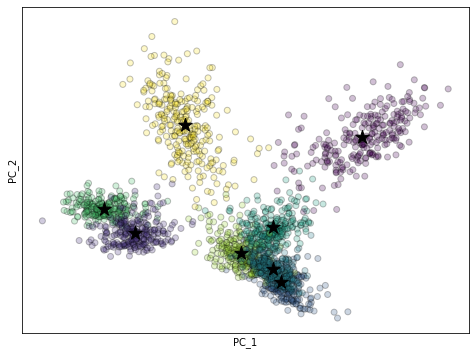

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

### 2.1.3 KMeans combinación de otros parámetros 1

Tambien se aplica una mayor reducción

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=20, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

* init: k-means++
* n_init =20
* max_iter= 300
* tolfloat=1e-4
* algorithm=”lloyd”

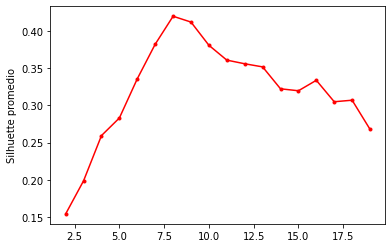

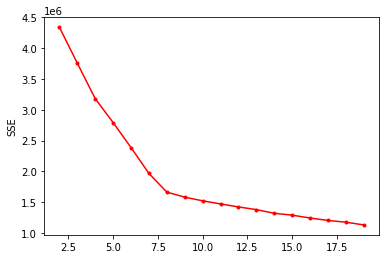

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    Kmeans = KMeans(n_clusters=k, random_state=22).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

KMeans(random_state=22)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

Clipping cluster size from 238 to 10
Clipping cluster size from 245 to 10
Clipping cluster size from 249 to 10
Clipping cluster size from 259 to 10
Clipping cluster size from 250 to 10
Clipping cluster size from 249 to 10
Clipping cluster size from 263 to 10
Clipping cluster size from 247 to 10


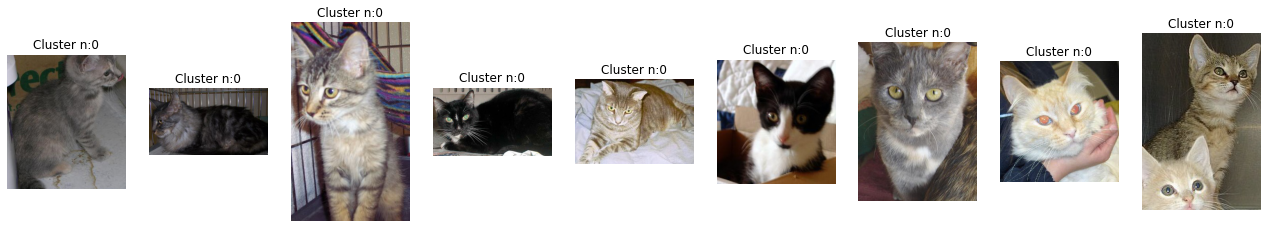

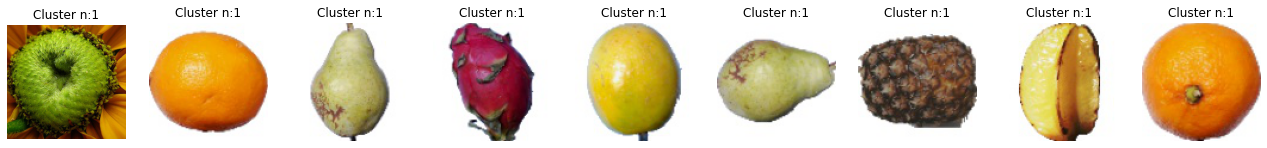

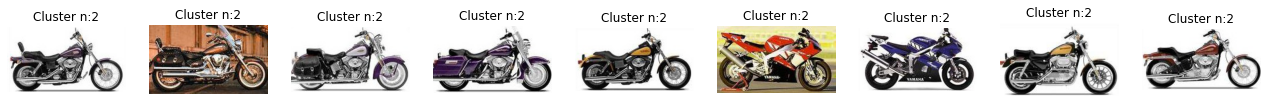

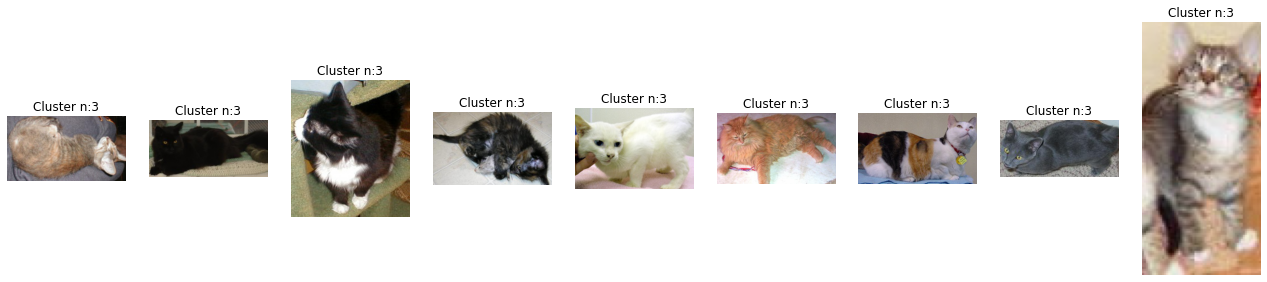

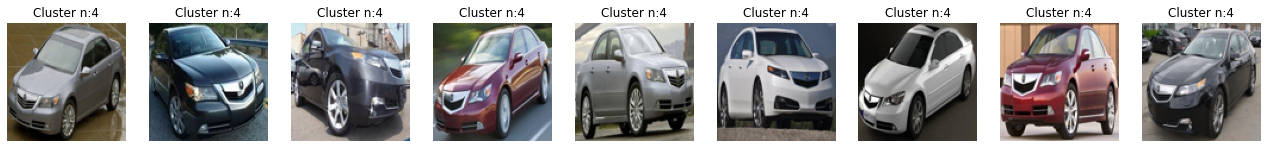

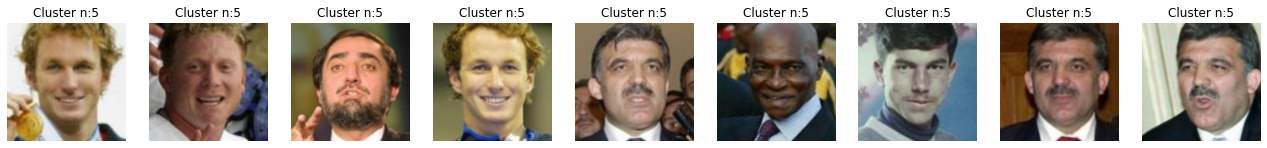

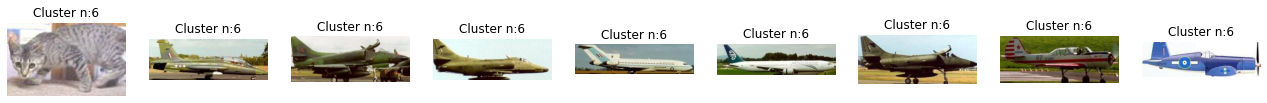

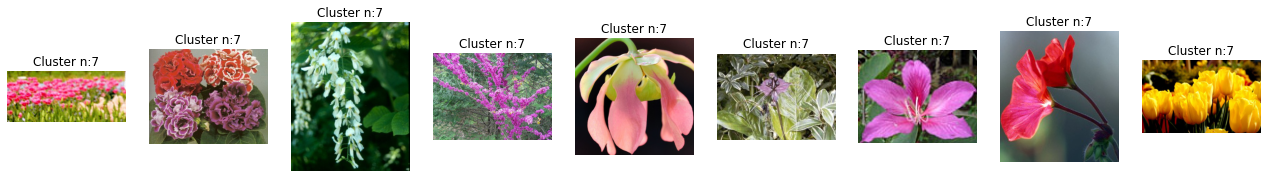

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:

df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['cat' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['flower' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['car' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['fruit' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['dog' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['airplane' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['person' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['motorbike' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

path     Labels Labels_test
0    /content/drive/MyDrive/Colab Notebooks/natural...        cat         cat
1    /content/drive/MyDrive/Colab Notebooks/natural...        cat         cat
2    /content/drive/MyDrive/Colab Notebooks/natural...        cat         cat
3    /content/drive/MyDrive/Colab Notebooks/natural...        cat         cat
4    /content/drive/MyDrive/Colab Notebooks/natural...        cat         cat
..                                                 ...        ...         ...
242  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike      flower
243  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike      flower
244  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike      flower
245  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike      flower
246  /content/drive/MyDrive/Colab Notebooks/natural...  motorbike      flower

[2000 rows x 3 columns]

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

path  Labels Labels_test
0  /content/drive/MyDrive/Colab Notebooks/natural...  flower      flower

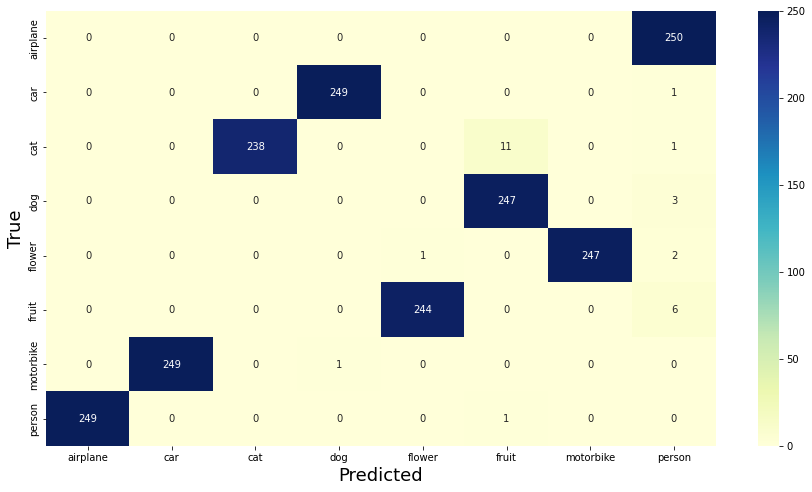

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

0.9933271635817909

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


In [ ]:
vanDongen(ct)

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


#### (d) Discuta brevemente los resultados obtenidos.

Conclusiones:
En los tres variantes propuestas se obtiene muy buenos resultados. Indice de rand superior a 0,99 y indice de van dongen inferior a 0.02. En el caso que se aumento los parametros n_init,max_iter= 300 y disminuir el tol se obtuvieron peores resultados que los valores por default. En el tercer caso se dejaron los parametros por default y se realizó una mayor reducción (20). Dío perores resultados pero de igual modo se obtuvo un buen valor. 

## 2.2 Algoritmo **2** de clustering
En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.

#### (a) **Aplicar Algoritmo 2 clustering** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters****


#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

## 2.3 Clustering **Jerárquico Aglomerativo**
En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.

Tipo de Variables: despues de la generacion de Features con VGG16 y la reduccion PCA --> quedan **VARIABLES CONTINUAS**


In [ ]:
#1ro vemos las features que tenemos: ¿que tipo de variable son (continua, mixta, enteros)? para ver cuales medidas de similaridad usar
pd.DataFrame(x).describe()

0             1             2             3             4   \
count  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean  -7.324219e-07 -4.882813e-07 -1.220703e-07  9.765625e-07  1.220703e-07   
std    2.130461e+01  1.867394e+01  1.669340e+01  1.636124e+01  1.524975e+01   
min   -4.624229e+01 -2.940927e+01 -3.708295e+01 -2.598486e+01 -2.843206e+01   
25%   -2.074492e+01 -1.351414e+01 -1.248577e+01 -1.039853e+01 -1.113179e+01   
50%    6.313784e+00 -6.057429e+00 -1.628255e+00 -6.257026e+00 -6.737223e-01   
75%    1.438998e+01  8.713791e+00  1.165864e+01  7.712539e+00  3.828498e+00   
max    5.334694e+01  6.923392e+01  4.626411e+01  7.375695e+01  5.732598e+01   

                 5             6             7             8             9   \
count  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean  -4.882813e-07 -2.441406e-07 -1.525879e-08 -3.051758e-08 -4.577637e-08   
std    1.417772e+01  1.222894e+01  8.696950e+00  7.693504e+00  7.484016e+00   
min   -3.774194e+01 -3.343270e+01 -3.420238e+01 -2.942370e+01 -2.642130e+01   
25%   -5.973100e+00 -6.128492e+00 -4.494433e+00 -3.827801e+00 -4.710491e+00   
50%    4.730233e-01 -2.590496e+00 -3.352890e-01 -7.137064e-02  1.699966e-01   
75%    5.530925e+00  1.247248e+00  3.414200e+00  4.057051e+00  4.565454e+00   
max    4.896505e+01  6.100975e+01  5.168917e+01  3.321052e+01  2.889753e+01   

       ...            90            91            92            93  \
count  ...  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean   ...  3.051758e-08  2.822876e-07 -9.536743e-08  2.479553e-08   
std    ...  2.800418e+00  2.778963e+00  2.762329e+00  2.728471e+00   
min    ... -9.771939e+00 -1.138366e+01 -1.327678e+01 -1.177564e+01   
25%    ... -1.865418e+00 -1.682430e+00 -1.710184e+00 -1.713479e+00   
50%    ... -7.216395e-02 -7.375956e-03 -3.180106e-02  4.623991e-02   
75%    ...  1.794253e+00  1.611061e+00  1.683167e+00  1.729057e+00   
max    ...  1.103556e+01  1.214724e+01  1.390353e+01  1.370151e+01   

                 94            95            96            97            98  \
count  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean  -9.727478e-08  3.776550e-07  7.247925e-08 -4.920959e-07  6.408691e-07   
std    2.705717e+00  2.687950e+00  2.677630e+00  2.668218e+00  2.643356e+00   
min   -1.122238e+01 -1.284135e+01 -9.162879e+00 -1.154663e+01 -1.490315e+01   
25%   -1.675152e+00 -1.619958e+00 -1.694718e+00 -1.691863e+00 -1.590479e+00   
50%   -5.120660e-02  7.132494e-02  1.533598e-02  1.061715e-03 -3.086286e-02   
75%    1.628005e+00  1.663821e+00  1.654328e+00  1.667244e+00  1.670932e+00   
max    1.238191e+01  1.356011e+01  1.206628e+01  1.280653e+01  1.524853e+01   

                 99  
count  2.000000e+03  
mean   1.697540e-07  
std    2.605521e+00  
min   -1.207326e+01  
25%   -1.643053e+00  
50%    4.866184e-02  
75%    1.586401e+00  
max    1.400172e+01  

[8 rows x 100 columns]

In [ ]:
pd.DataFrame(x).shape

(2000, 100)

In [ ]:
pd.DataFrame(x).head()

0          1          2          3         4          5         6   \
0 -15.495527  30.320061   5.170109   9.354141  5.402992   5.733096 -2.880776   
1  -5.353551  24.899521   2.185037  10.063537  6.835893  13.183122 -3.225012   
2 -20.408535  26.903633   8.437925   8.187300  5.138012   7.545345  0.932211   
3 -16.840523  45.974594  19.113964  15.362490  8.123312  10.360698 -0.678052   
4 -12.244107  30.109594  11.067749  10.241977  6.149254   7.087711  2.904194   

          7         8         9   ...        90        91        92        93  \
0   4.283452 -0.035616  6.094730  ... -3.275706 -4.382640 -1.106296 -2.398035   
1  19.651197  2.289893  1.463446  ... -3.525994 -2.417202 -5.514266  0.396829   
2   8.039602  1.462596 -6.992920  ... -3.124671 -2.843405 -4.246041  0.210854   
3   0.000559 -8.147443  1.745638  ...  1.987756  0.644059  2.567128  1.448224   
4  -1.114023 -8.292921 -8.366324  ... -1.984531  4.329049  2.612831 -2.725959   

         94        95        96        97        98        99  
0  6.087319 -3.223211  0.618620  1.622661 -0.538746  2.897302  
1  2.476740  0.923207 -6.131951 -0.778819 -2.462322 -1.402297  
2  2.469912 -0.187561 -2.078592  0.933609 -0.955924  0.551677  
3  1.115779  3.532695  3.416398 -2.898413  0.744439  0.929384  
4  3.472748  0.594232  0.337852  1.345463 -2.736372  4.014753  

[5 rows x 100 columns]

Selecion 50 imagenes para cada Categoria para poder graficar mejor los resultados:

In [350]:
#Como 250 imagenes es mucho para una graficar la matriz de distancia -> tomo n = 50 ejemplos de cada categoria
n = 50
ini = ejn.iloc[0,:]

xm = list()
for i in ini:
  xm = xm + list(x[i:(i+n)])
xm = np.array(xm)

print(len(xm), len(xm[0]))

400 100


In [362]:
#AUX: Genero las etiquetas de las 400 imagenes (n = 50 x 8 categ.) seleccionadas que se grafican:
n = 50
ini = ejn.iloc[0,:]

lbs = list()
for i in ini:
  lbs = lbs + list(df_labels_m.label[i:(i+n)])
lbs = np.array(lbs)

#### (a) **Aplicar Clustering Jerarquico Aglomerativos** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters****


OPCION 1: Hacer scalado de los datos o NO hacer escalado de los datos:

puesto que los datos son todas imagenes y que a su vez los features fueron generados con el mismo modelo para todas, no deberia de haber diferencia significativa a priori en las escalas de medición. 

Pero se puede probar a ver si mejora y para tener una opcion mas

1ro) Genero la **Matriz de Distancia Inicial:**

**Distancia de Similaridad**, opciones:
> Euclidia

> Manhatan

> Minkowski

> Mahalanobis

---



In [366]:
#1 Matriz de Distancia --> con distancia gower
matdist_gow = gower.gower_matrix(xm) #cambiar o probar con otras distancias para continuas (no gower que es para var mixtas)

La Matriz de distancia original --> ya esta ordenada por Categorias, puesto que asi estan ordenadas las imagenes originalmente

sin embarlo al calcular el cluster jerarquico, las reordena de manera diferente.

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


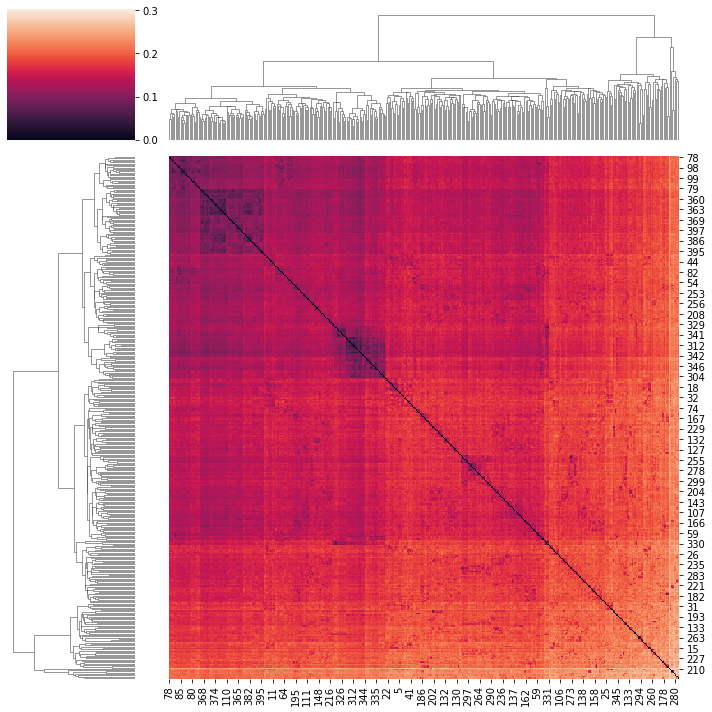

In [367]:
#2 GRAFICA la matriz de distancia armando un cluster jerarquico:
sns.clustermap(matdist_gow)

2do) Elección de Algoritmo para medir distancia entre Clusters y agruparlos:  

-> **linkage**(*matriz_distancia_inicial*, **'metodo'**) -> ver configuraciones posibles
> **WARD**

> vecino más cercano

> vinculación promedio

In [ ]:
#Clustering Jerarquico Aglomerativo: 
Z = linkage(matdist_gow, 'ward') #usa método Ward o de varianza mínima, entre las alternativas existentes para agrupamiento entre clusters.

3ro) Calculo de **Coeficiente de Correlación Cofenético**:

Mide la correlación entre la matriz de distancia que dio origen al agrupamiento y los distancias extraídas del árbol (Altura del nodo que une por primera vez dos elementos).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


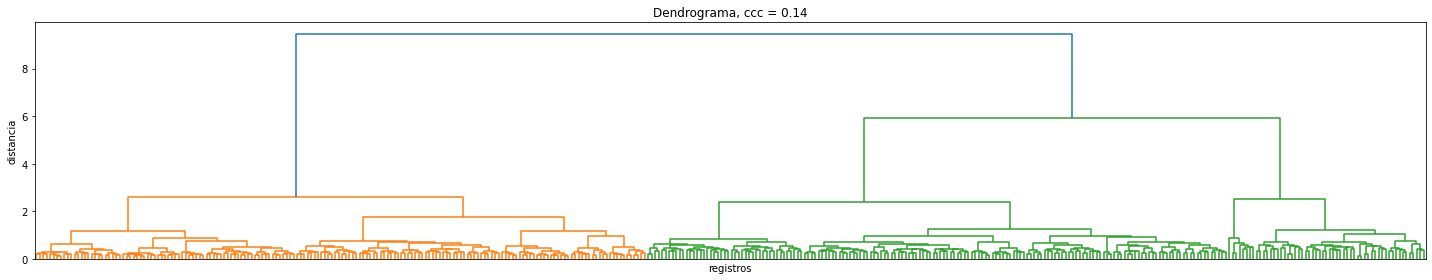

In [352]:
#Clustering Jerarquico Aglomerativo: 
Z = linkage(matdist_gow, 'ward') #usa método Ward o de varianza mínima, entre las alternativas existentes para agrupamiento entre clusters.
c,_=cophenet(Z,Y=squareform(matdist_gow)) # calcula el Coeficiente de Correlación Cofenético
plt.title('Dendrograma, ccc = %0.2f'%c)
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(Z,no_labels=True)

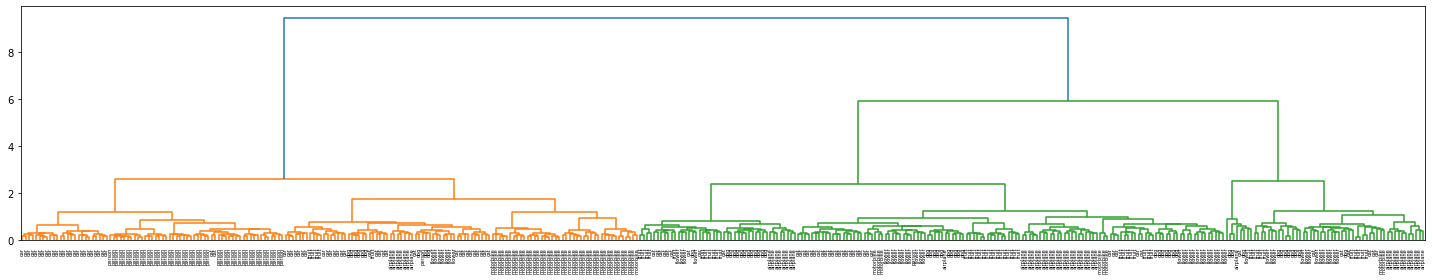

In [363]:
dn = dendrogram(Z, labels = lbs)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

## 2.4 **Comparar** y discutir brevemente los resultados obtenidos.

# 3. **Detección de objetos dentro de una imagen**

### 3.2 -> NO se que haces ¿esta repetido?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters
import skimage.measure


#### (a) Seleccionar una sóla imagen.

In [ ]:
    # load the image
    image = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0123.jpg')
    plt.imshow(image)

#### (b) Convertir la imagen a binaria.

In [ ]:

    # convert the image to grayscale
    gray_image = skimage.color.rgb2gray(image)
    # denoise the image with a Gaussian filter
    #blurred_image = skimage.filters.gaussian(gray_image, sigma=2)
    # mask the image according to threshold
    binary_mask = blurred_image < 0.56

    plt.imshow(binary_mask)
    

#### (c) Aplicar los algoritmos de **Connected-component labelling** y **clustering espectral** sobre los pixels.

Connected_component labelling

In [ ]:
# perform connected component analysis
labeled_image, count = skimage.measure.label(binary_mask, connectivity=2, return_num=True)
plt.imshow(labeled_image)

In [ ]:
count

clustering espectral 

#### (d) Describir el proceso y **comparar los resultados** obtenidos.

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


#### (a) Seleccionar una sóla imagen.

In [ ]:
# Loading the image
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0123.jpg')
cv2_imshow(img)

#### (b) Convertir la imagen a binaria.

In [ ]:
# preprocess the image
gray_img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
# Applying 7x7 Gaussian Blur
blurred = cv2.GaussianBlur(gray_img, (7, 7), 0)
threshold = cv2.threshold(blurred, 0, 125,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(threshold)

#### (c) Aplicar los algoritmos de **Connected-component labelling** y **clustering espectral** sobre los pixels.

Connected_component labelling

In [ ]:
# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(threshold,
                                            4,
                                            cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
 
# Initialize a new image to
# store all the output components
output = np.zeros(gray_img.shape, dtype="uint8")
 
# Loop through each component
for i in range(1, totalLabels):
   
      # Area of the component
    area = values[i, cv2.CC_STAT_AREA]
     
    if (area > 1400) and (area < 4000000000):
        # Create a new image for bounding boxes
        new_img=img.copy()
         
        # Now extract the coordinate points
        x1 = values[i, cv2.CC_STAT_LEFT]
        y1 = values[i, cv2.CC_STAT_TOP]
        w = values[i, cv2.CC_STAT_WIDTH]
        h = values[i, cv2.CC_STAT_HEIGHT]
         
        # Coordinate of the bounding box
        pt1 = (x1, y1)
        pt2 = (x1+ w, y1+ h)
        (X, Y) = centroid[i]
         
        # Bounding boxes for each component
        cv2.rectangle(new_img,pt1,pt2,
                      (0, 255, 0), 3)
        cv2.circle(new_img, (int(X),
                             int(Y)),
                   4, (0, 0, 255), -1)
 
        # Create a new array to show individual component
        component = np.zeros(gray_img.shape, dtype="uint8")
        componentMask = (label_ids == i).astype("uint8") * 255
 
        # Apply the mask using the bitwise operator
        component = cv2.bitwise_or(component,componentMask)
        output = cv2.bitwise_or(output, componentMask)
         
        # Show the final images
        cv2_imshow(new_img)
        cv2_imshow(component)
        cv2_imshow(output)

clustering espectral 

In [ ]:
from sklearn.feature_extraction import image
mask = threshold.astype(bool)
graph = image.img_to_graph(threshold, mask=mask)

In [ ]:
graph.data = np.exp(-graph.data / graph.data.std())

In [ ]:
graph.shape


tarda 15 minutos

In [ ]:
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=6, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

In [ ]:
label_im

In [ ]:
a=np.where((label_im == 0),0.5,-1 )

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(a)

#### (d) Describir el proceso y **comparar los resultados** obtenidos.